# Sigmoid Pedestal Model Visualization

This notebook visualizes the **Sigmoid Pedestal** model used for the thermal diffusivity $\chi(\rho)$ in the Torax project.

The model captures the L-H transition structure using a parameterized profile:

$$ \chi(\rho) = \chi_{\text{core}} + (\chi_{\text{edge}}(z) - \chi_{\text{core}}) \cdot \sigma\left(\frac{\rho - \rho_{\text{ped}}}{w_{\text{ped}}}\right) $$

where:
*   $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the standard logistic sigmoid function.
*   $z$ is the latent variable controlling the transition.
*   $\chi_{\text{edge}}(z)$ is the dynamic edge diffusivity.

The edge diffusivity is defined as:
$$ \chi_{\text{edge}}(z) = \chi_{\text{edge,base}} - \chi_{\text{edge,drop}} \cdot \sigma(k z) $$

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [7]:
# Model Parameters
CHI_CORE = 0.6
CHI_EDGE_BASE = 2.0
CHI_EDGE_DROP = 1.0
RHO_PED = 0.85
W_PED = 0.08
K_GAIN = 3.0  # Latent gain/stiffness

def sigmoid(x):
    """Standard logistic sigmoid function."""
    return 1.0 / (1.0 + np.exp(-x))

def get_chi_edge(z):
    """Calculate dynamic edge diffusivity based on latent variable z."""
    # chi_edge(z) = chi_edge_base - chi_edge_drop * sigma(k * z)
    return CHI_EDGE_BASE - CHI_EDGE_DROP * sigmoid(K_GAIN * z)

def get_chi_profile(rho, z):
    """
    Calculate the full thermal diffusivity profile chi(rho).
    
    Args:
        rho: Array of radial coordinates [0, 1]
        z: Latent variable scalar
    """
    chi_edge_val = get_chi_edge(z)
    
    # Pedestal shape function
    # sigma((rho - rho_ped) / w_ped)
    shape = sigmoid((rho - RHO_PED) / W_PED)
    
    # Full profile
    # chi(rho) = chi_core + (chi_edge(z) - chi_core) * shape
    chi = CHI_CORE + (chi_edge_val - CHI_CORE) * shape
    return chi

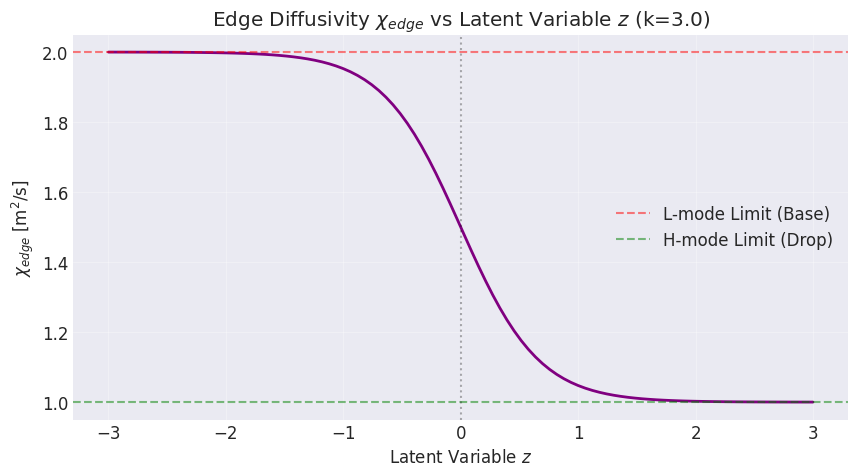

In [8]:
# Visualize Edge Diffusivity vs Latent Variable z
z_values = np.linspace(-3, 3, 100)
chi_edge_values = get_chi_edge(z_values)

plt.figure(figsize=(10, 5))
plt.plot(z_values, chi_edge_values, linewidth=2, color='purple')
plt.axhline(y=CHI_EDGE_BASE, color='r', linestyle='--', alpha=0.5, label='L-mode Limit (Base)')
plt.axhline(y=CHI_EDGE_BASE - CHI_EDGE_DROP, color='g', linestyle='--', alpha=0.5, label='H-mode Limit (Drop)')
plt.axvline(x=0, color='k', linestyle=':', alpha=0.3)

plt.title(rf'Edge Diffusivity $\chi_{{edge}}$ vs Latent Variable $z$ (k={K_GAIN})')
plt.xlabel(r'Latent Variable $z$')
plt.ylabel(r'$\chi_{edge}$ [m$^2$/s]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

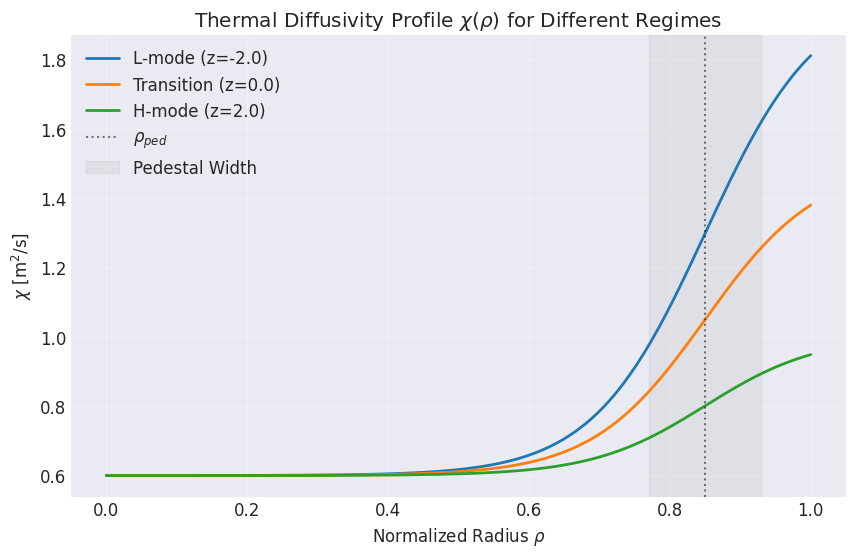

In [9]:
# Visualize Radial Profiles for different z values
rho = np.linspace(0, 1, 200)

# Define z values for different regimes
z_scenarios = [
    (-2.0, 'L-mode (z=-2.0)'),
    (0.0, 'Transition (z=0.0)'),
    (2.0, 'H-mode (z=2.0)')
]

plt.figure(figsize=(10, 6))

for z_val, label in z_scenarios:
    chi = get_chi_profile(rho, z_val)
    plt.plot(rho, chi, linewidth=2, label=label)

# Mark pedestal region
plt.axvline(x=RHO_PED, color='k', linestyle=':', alpha=0.5, label=r'$\rho_{ped}$')
plt.axvspan(RHO_PED - W_PED, RHO_PED + W_PED, color='gray', alpha=0.1, label='Pedestal Width')

plt.title(r'Thermal Diffusivity Profile $\chi(\rho)$ for Different Regimes')
plt.xlabel(r'Normalized Radius $\rho$')
plt.ylabel(r'$\chi$ [m$^2$/s]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

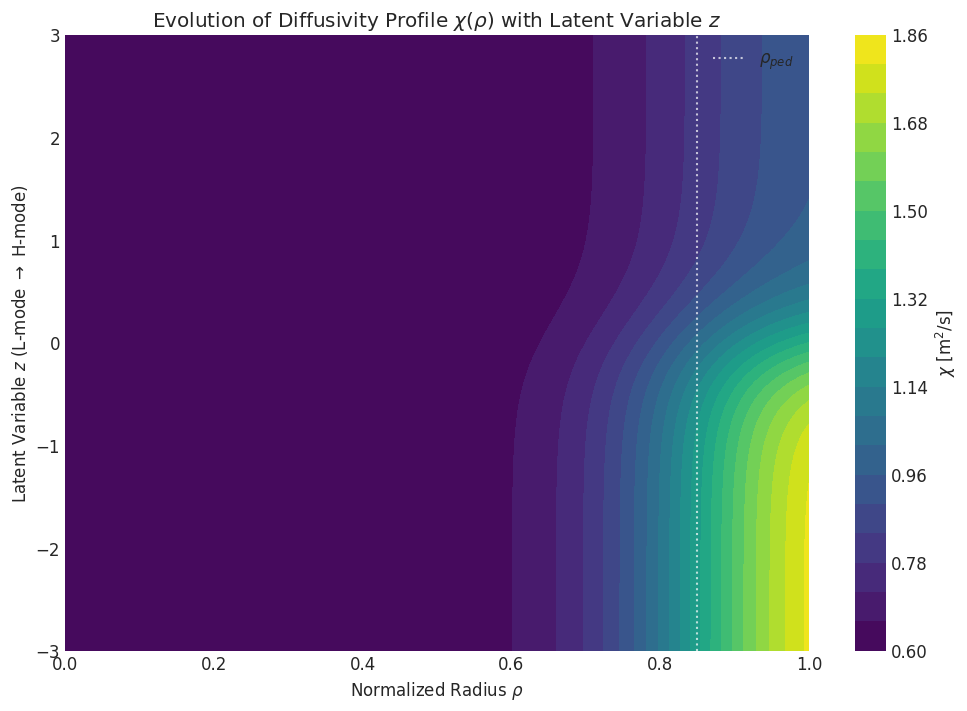

In [10]:
# Heatmap of Chi Profile Evolution
rho_grid = np.linspace(0, 1, 100)
z_grid = np.linspace(-3, 3, 100)

R, Z = np.meshgrid(rho_grid, z_grid)
CHI_GRID = np.zeros_like(R)

for i in range(len(z_grid)):
    CHI_GRID[i, :] = get_chi_profile(rho_grid, z_grid[i])

plt.figure(figsize=(12, 8))
contour = plt.contourf(R, Z, CHI_GRID, levels=20, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label(r'$\chi$ [m$^2$/s]')

plt.axvline(x=RHO_PED, color='white', linestyle=':', alpha=0.7, label=r'$\rho_{ped}$')
plt.title(r'Evolution of Diffusivity Profile $\chi(\rho)$ with Latent Variable $z$')
plt.xlabel(r'Normalized Radius $\rho$')
plt.ylabel(r'Latent Variable $z$ (L-mode $\to$ H-mode)')
plt.legend()
plt.show()